In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from datetime import datetime, timedelta



In [4]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [5]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

In [6]:
birds_recep.count()

2309123

## Map utils

In [7]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


In [8]:
def group_emisions(data):
    data_dict = data.asDict()
    recep_0 = data_dict.pop('recep_0')
    recep_1 = data_dict.pop('recep_1')
    recep_2 = data_dict.pop('recep_2')
    recep_3 = data_dict.pop('recep_3')
    
    data_dict['emissions'] = []
    for i in range(24):
        data_dict['emissions'].append([recep_0[i], recep_1[i], recep_2[i], recep_3[i]])
    return data_dict


In [9]:
points_emisions = points_recep.map(group_emisions)


In [10]:
def expand_rows_with_emissions(row):
    emissions = row.pop('emissions')
    rows = []
    for e in emissions:
        new_row = row.copy()
        new_row['recep'] = e
        rows.append(new_row)
    return rows
        
all_emissions = points_emisions.flatMap(expand_rows_with_emissions)

### Genero los atributos y etiquetas que me interesan

In [11]:
def generate_attrs(row):
    data = {
        'antenna_0': row['recep'][0],
        'antenna_1': row['recep'][1],
        'antenna_2': row['recep'][2],
        'antenna_3': row['recep'][3],
    }
    return {'data': data, 'x': row['x'], 'y': row['y'], 'point': row['Punto']}
    
all_emissions = all_emissions.map(generate_attrs)

### Saco las emisiones sin ninguna recepcion

In [12]:
all_emissions = all_emissions.filter(lambda x: sum(x['data'].values())>0)

### Normalizo coordenadas

In [13]:
all_emissions = all_emissions.map(lambda x: normalize_positions(x))

### Regresion por eje

In [14]:
regre_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())
regre_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())



clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))

clf.fit(regre_data, regre_target)


MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='distance'),
           n_jobs=None)

In [15]:
GRID = [(1450, 1800), (2000, 2200)]
#GRID = [(1750, 1600), (2200, 2000)]

FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]


### Me quedo solo con pajaros etiquetados

In [140]:
birds_recep = birds_recep.filter(lambda x: x['tag_id'] in MALES+FEMALES)

### Obtengo cual es el dia inicial en el que todos los pajaros tienen chip

In [17]:
import pyspark.sql.functions as F
birds_recep_df = birds_recep.toDF()
birds_start_date = birds_recep_df.groupBy('tag_id').agg(F.min("timestamp"))
birds_start_date.agg(F.max('min(timestamp)')).collect()

[Row(max(min(timestamp))='2018-01-02 21:13:07')]

In [17]:
#start_date = '2018-01-03'
start_date = '2018-01-10' ## Fecha que me pasó Romina

### Obtengo cual es el dia final en el que todos los pajaros tienen chip

In [19]:
birds_end_date = birds_recep_df.groupBy('tag_id').agg(F.max("timestamp"))
birds_end_date.agg(F.min('max(timestamp)')).collect()

[Row(min(max(timestamp))='2018-01-26 15:27:50')]

In [18]:
end_date = '2018-01-26'
#end_date = '2018-02-08'

### Filtro a partir de la fecha obtenida

In [19]:
birds_recep = birds_recep.filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)

In [20]:
birds_recep.count()

1069514

In [21]:
START_TIME = '08:00:00'
END_TIME = '19:00:00'
birds_data_complete_df = birds_recep.filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME).toDF()
birds_data_complete_df.write.parquet('tmp/checkpoint-cog.parquet')



In [16]:
#birds_data_complete = birds_data_complete_df.toPandas()
birds_data_complete = pd.read_parquet('tmp/checkpoint-cog.parquet')
birds_data = birds_data_complete.drop(columns=['tag_id','timestamp'])

In [17]:
predictions = clf.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(birds_data_complete)], axis=1).values

In [18]:
from datetime import datetime

WINDOW_SIZE = 60
STEP_SIZE = 10

smooth_predictions = []
window_predictions = []

init_time_map = {}
for i in range(len(predictions)):
    prediction = predictions[i]
    bird_id = prediction[6]
    init_time = init_time_map.get(bird_id)
    if init_time is not None:
        new_init_time = datetime.strptime(prediction[7], '%Y-%m-%d %H:%M:%S')
        delta = new_init_time - init_time
        if delta.total_seconds() <= STEP_SIZE:
            continue
    window_predictions = []
    window_predictions.append(prediction)
    init_time = datetime.strptime(prediction[7], '%Y-%m-%d %H:%M:%S')
    init_time_map[bird_id] = init_time
    for j in range(i+1, len(predictions)):
        next_prediction = predictions[j]
        if bird_id != next_prediction[6]:
            continue
        time_diff = datetime.strptime(next_prediction[7], '%Y-%m-%d %H:%M:%S') - init_time
        if time_diff.total_seconds() <= WINDOW_SIZE:
            window_predictions.append(next_prediction)
        else:
            break
    window_predictions_np = np.array(window_predictions)
    x = window_predictions_np[:,0].mean()
    y = window_predictions_np[:,1].mean()
    smooth_predictions.append([x, y, None, None, None, None, bird_id, window_predictions[0][7]])
      

In [19]:
USE_SMOOTH_PREDICTION = True

if USE_SMOOTH_PREDICTION:
    smooth_predictions_np = np.array(smooth_predictions)
else:
    smooth_predictions_np = np.array(predictions)

In [20]:
grid_predictions = []
for i in range(len(smooth_predictions_np)):
    prediction = smooth_predictions_np[i]
    if GRID[0][0] <= prediction[0] <= GRID[1][0] and GRID[0][1] <= prediction[1] <= GRID[1][1]:
        grid_pred = np.insert(prediction, 8,'in_grid', axis=0)
    else:
        grid_pred = np.insert(prediction, 8,'out_grid', axis=0)
    grid_predictions.append(grid_pred)

In [21]:
grid_predictions = pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


In [26]:
int(3)/2

1.5

In [27]:
def get_bird_timestamp_in_grid(bird_data):
    DELTA_TIME_IN_SEC = int((5 if not USE_SMOOTH_PREDICTION else 5+STEP_SIZE)/2)
    timestamp_in_grid = []
    for row in bird_data['time']:
        real_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        for i in range(-DELTA_TIME_IN_SEC, DELTA_TIME_IN_SEC+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append(datetime.strftime(res, '%Y-%m-%d %H:%M:%S'))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['time'])

male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions['region'] == 'in_grid')]

matches_per_bird = {}
for female_bird in FEMALES:
    female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions['region'] == 'in_grid')]
    timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid)
    
    male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index('time'), on='time', how='inner')

    female_matches = {}
    for index, row in male_in_grid_with_female.iterrows():
        tag = row['tag']
        current_matches = female_matches.get(tag, 0)
        female_matches[tag] = current_matches+1

    matches_per_bird[female_bird] = female_matches



In [28]:
for female_id in matches_per_bird.keys():
    males_matches = matches_per_bird[female_id]
    without_match = MALES-males_matches.keys()
    for b in without_match:
        matches_per_bird[female_id][b] = 0
    


In [29]:
matrix_res = [[]] * len(FEMALES)
for i in range(len(FEMALES)):
    matrix_res[i] = []
    for m in MALES:
        matrix_res[i].append(matches_per_bird.get(FEMALES[i]).get(m, 0))
    

<IPython.core.display.Javascript object>


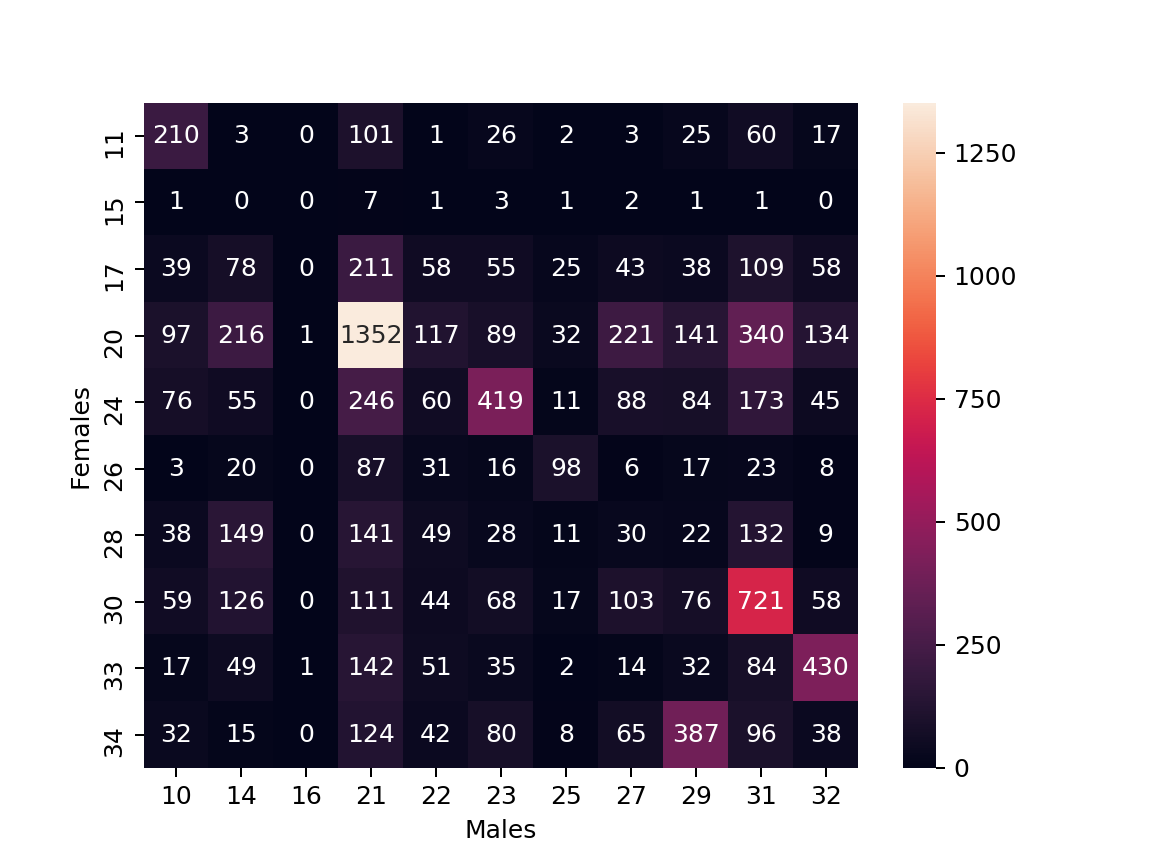

[Text(50.7222,0.5,'Females'), Text(0.5,23.5222,'Males')]

In [47]:
import seaborn as sn
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g')
ax.set(xlabel='Males', ylabel='Females')

<IPython.core.display.Javascript object>


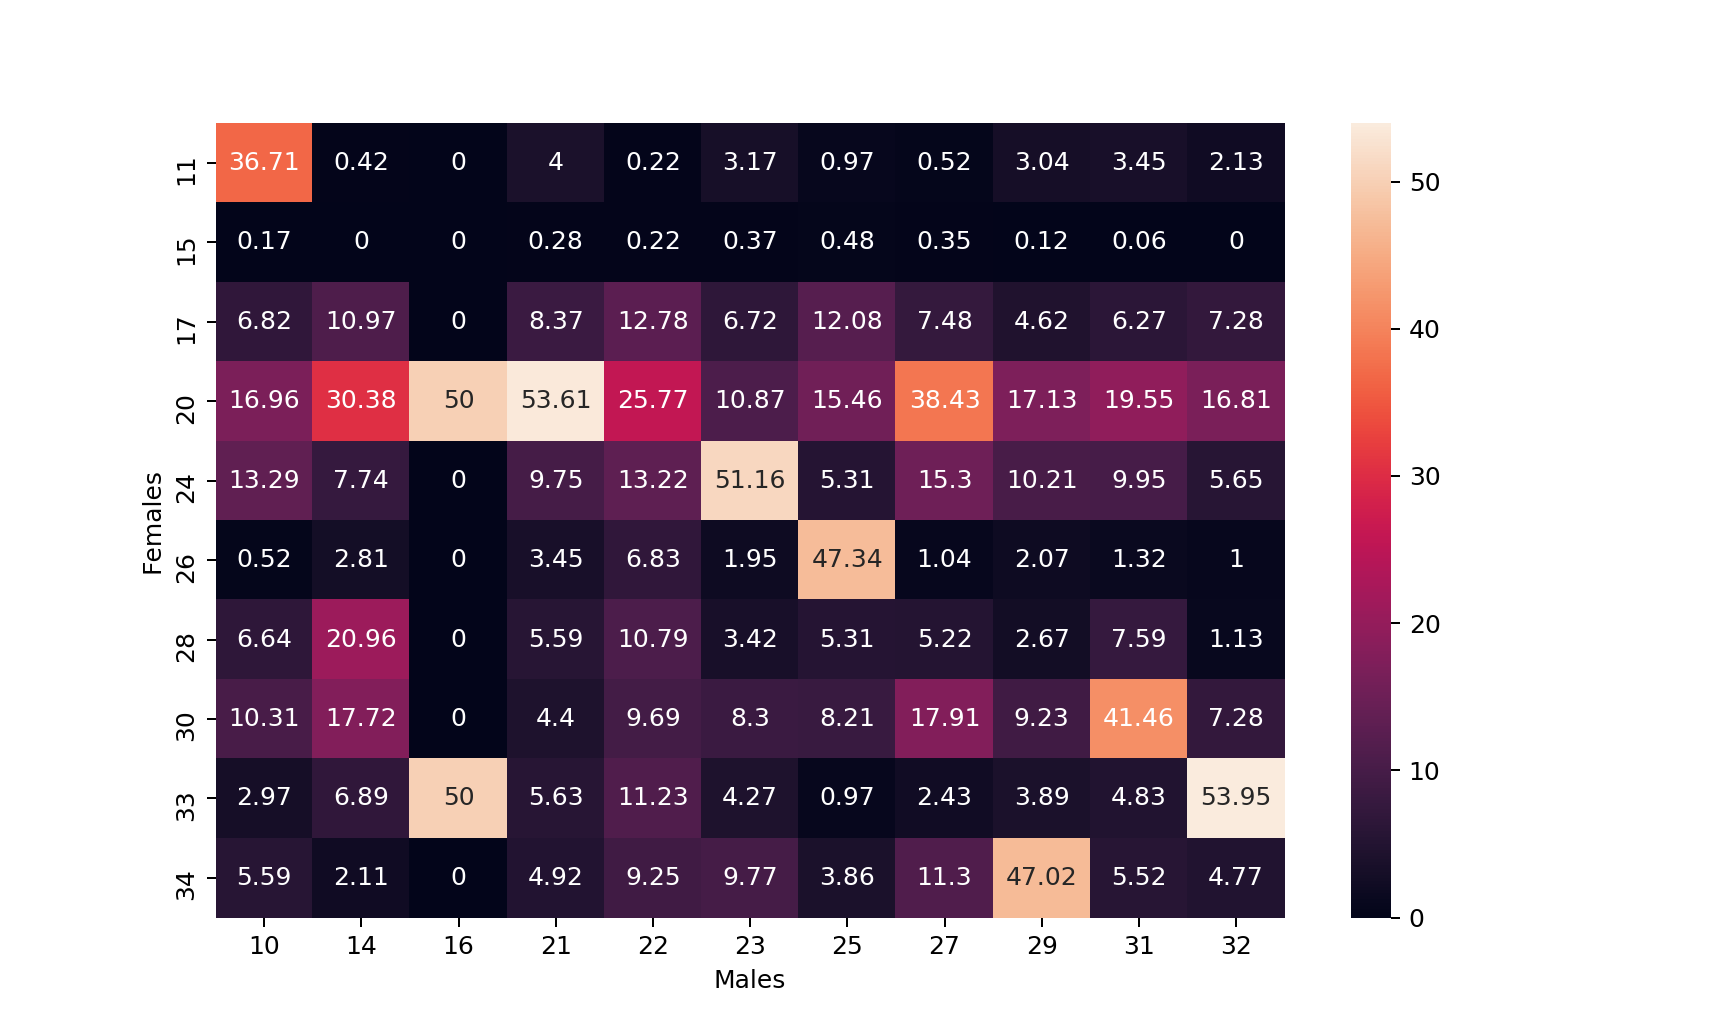

[Text(50.7222,0.5,'Females'), Text(0.5,23.5222,'Males')]

In [46]:
### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
### con cualquier hembra estuvieron juntos

import seaborn as sn
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g')
ax.set(xlabel='Males', ylabel='Females')